## Preparando o ambiente

In [1]:
# importando as bibliotecas necessárias

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, f1_score

In [2]:
# Alterando as configurações do pandas para que sejam visualizadas todas as colunas
pd.set_option('display.max_columns', None)

# Lendo os dados e criando um dataframe
df = pd.read_csv('train.csv').drop('id', axis=1)

# dividindo as bases
train, test = train_test_split(df, test_size=0.3, random_state=42)
test, val = train_test_split(test, test_size=0.333, random_state=42)

In [3]:
# Criando cópias dos dataframes

train_orig = train.copy()
val_orig = val.copy()
test_orig = test.copy()

In [4]:
# Verificando o tamanho das amostras

train.shape, val.shape, test.shape

((3943, 20), (564, 20), (1127, 20))

## Análise exploratória dos dados

Entendendo as colunas:
- id: identificação do cliente
- gender: sexo do cliente
- SeniorCitizen: indicador se é um(a) idoso(a)
- Partner: indicador se tem um parceiro(a)
- Dependents: indicador se possui dependentes
- tenure: quantos meses o cliente está na empresa
- PhoneService: indicador se possui serviços de telefonia
- MultipleLines: indicador se possui múltiplas linhas telefônicas
- InternetService: indicador se possui serviços de internet
- OnlineSecurity: indicador se possui serviços de segurança online
- OnlineBackup: indicador se possui serviços de backup online
- DeviceProtection: indicador se possui serviços de proteção de equipamentos
- TechSupport: indicador se possui serviços de suporte técnico
- StreamingTV: indicador se possui serviços de streaming de tv
- StreamingMovies: indicador se possui serviços de streaming de filmes
- Contract: tipo de contrato
- PaperlessBilling: indicador se a cobrança é via papel ou não (cobrança eletrônica)
- PaymentMethod: indicador do tipo de pagamento
- MonthlyCharges: valor mensal dos serviços
- TotalCharges: valor total dos serviços desde o início do contrato
- Churn: indicador se saiu da empresa ou não

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 680 to 860
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            3943 non-null   object 
 1   SeniorCitizen     3943 non-null   int64  
 2   Partner           3943 non-null   object 
 3   Dependents        3797 non-null   object 
 4   tenure            3622 non-null   float64
 5   PhoneService      3943 non-null   object 
 6   MultipleLines     3943 non-null   object 
 7   InternetService   3943 non-null   object 
 8   OnlineSecurity    3943 non-null   object 
 9   OnlineBackup      3943 non-null   object 
 10  DeviceProtection  3943 non-null   object 
 11  TechSupport       3943 non-null   object 
 12  StreamingTV       3943 non-null   object 
 13  StreamingMovies   3943 non-null   object 
 14  Contract          3943 non-null   object 
 15  PaperlessBilling  3943 non-null   object 
 16  PaymentMethod     3875 non-null   object 

In [6]:
# visão inicial do dataset

train.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
680,Male,0,No,No,7.0,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.35,631.85,1
180,Female,0,No,No,3.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,19.85,57.2,0
4181,Male,0,No,No,62.0,Yes,No,DSL,Yes,Yes,No,No,Yes,Yes,One year,Yes,Credit card (automatic),74.30,4698.05,0
1894,Male,0,No,Yes,6.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.20,98.35,0
4013,Female,0,Yes,No,52.0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,105.05,5624.85,1


In [7]:
# verificando valores nulos

train.isna().sum()

gender                0
SeniorCitizen         0
Partner               0
Dependents          146
tenure              321
PhoneService          0
MultipleLines         0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
Contract              0
PaperlessBilling      0
PaymentMethod        68
MonthlyCharges        0
TotalCharges          0
Churn                 0
dtype: int64

In [8]:
# Transformando a coluna 'TotalCharges' em float.
train['TotalCharges'] = pd.to_numeric(train['TotalCharges'], errors='coerce')
val['TotalCharges'] = pd.to_numeric(val['TotalCharges'], errors='coerce')
test['TotalCharges'] = pd.to_numeric(test['TotalCharges'], errors='coerce')

# Separando as colunas numéricas das categoricas
colunas_numericas = [col for col in train.columns if train[col].dtype == 'float64' or train[col].dtype == 'int64']
colunas_categoricas = [col for col in train.columns if train[col].dtype == 'object']

# Fazendo um pequeno tratamento nos dados
for feature in colunas_categoricas:
    train[feature] = train[feature].str.lower()
    val[feature] = val[feature].str.lower()
    test[feature] = test[feature].str.lower()

In [9]:
# Verificando os valores presentes em cada categoria.

for feature in colunas_categoricas:
    print(f'A coluna {feature} possui {len(train[feature].unique())} distintos, sendo eles:')
    for value in train[feature].unique():
        print(value)
    print('')

A coluna gender possui 2 distintos, sendo eles:
male
female

A coluna Partner possui 2 distintos, sendo eles:
no
yes

A coluna Dependents possui 3 distintos, sendo eles:
no
yes
nan

A coluna PhoneService possui 2 distintos, sendo eles:
yes
no

A coluna MultipleLines possui 3 distintos, sendo eles:
yes
no
no phone service

A coluna InternetService possui 3 distintos, sendo eles:
fiber optic
no
dsl

A coluna OnlineSecurity possui 3 distintos, sendo eles:
no
no internet service
yes

A coluna OnlineBackup possui 3 distintos, sendo eles:
no
no internet service
yes

A coluna DeviceProtection possui 3 distintos, sendo eles:
yes
no internet service
no

A coluna TechSupport possui 3 distintos, sendo eles:
no
no internet service
yes

A coluna StreamingTV possui 3 distintos, sendo eles:
yes
no internet service
no

A coluna StreamingMovies possui 3 distintos, sendo eles:
no
no internet service
yes

A coluna Contract possui 3 distintos, sendo eles:
month-to-month
one year
two year

A coluna Paperle

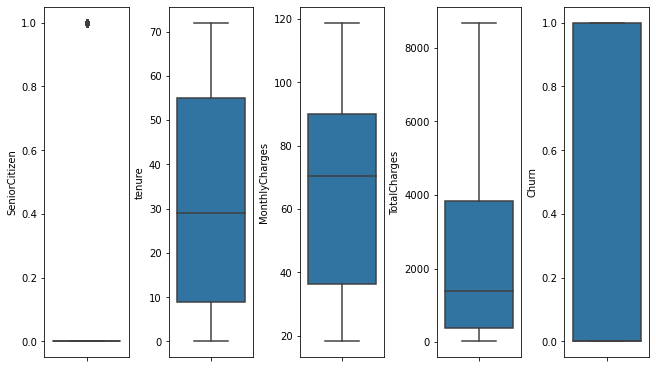

In [10]:
# Verificando a distribuição dos dados numéricos

fig, ax = plt.subplots(1, len(colunas_numericas), layout='constrained', figsize=(9, 5))

for i in range(len(colunas_numericas)):
    sns.boxplot(data=train, y=colunas_numericas[i], ax=ax[i])

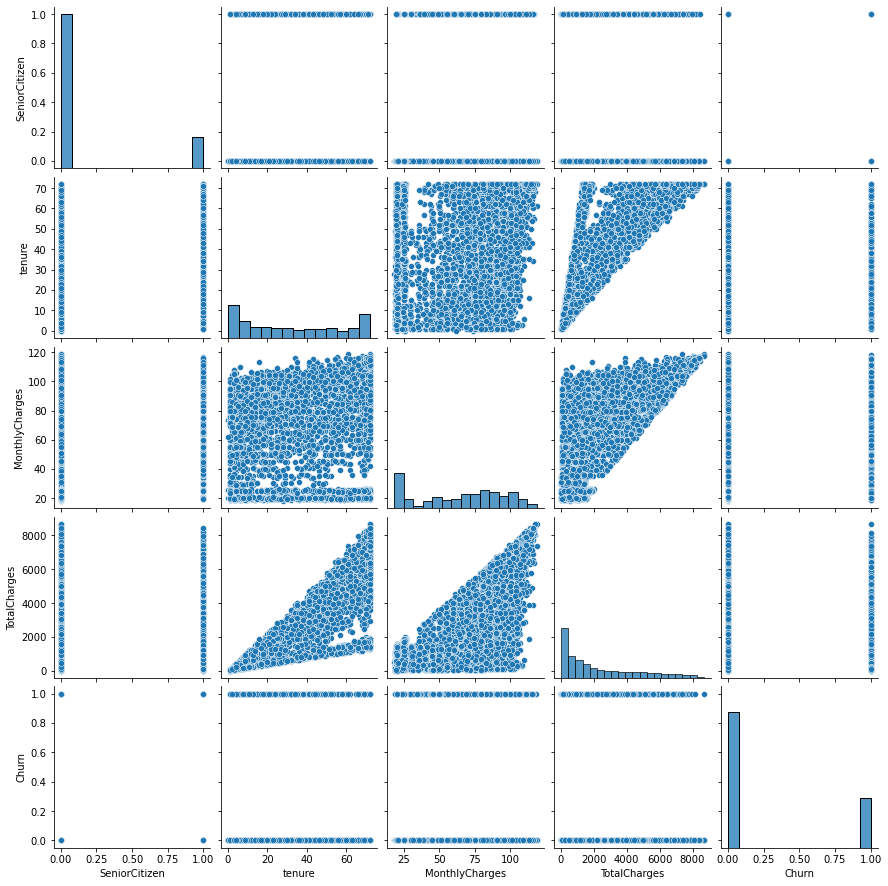

In [11]:
# Verificando a distribuição dos dados numéricos

sns.pairplot(data=train)
plt.show()

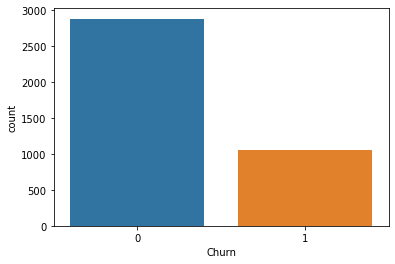

In [12]:
# Verificando a distribuição da variável target. Como é de se esperar, temos desbalanceamento.

sns.countplot(data=train, x=train['Churn'])
plt.show()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,male,0,no,no,1.0,yes,yes,fiber optic,no,no,no,no,no,no,month-to-month,yes,electronic check,74.4,20.2,1


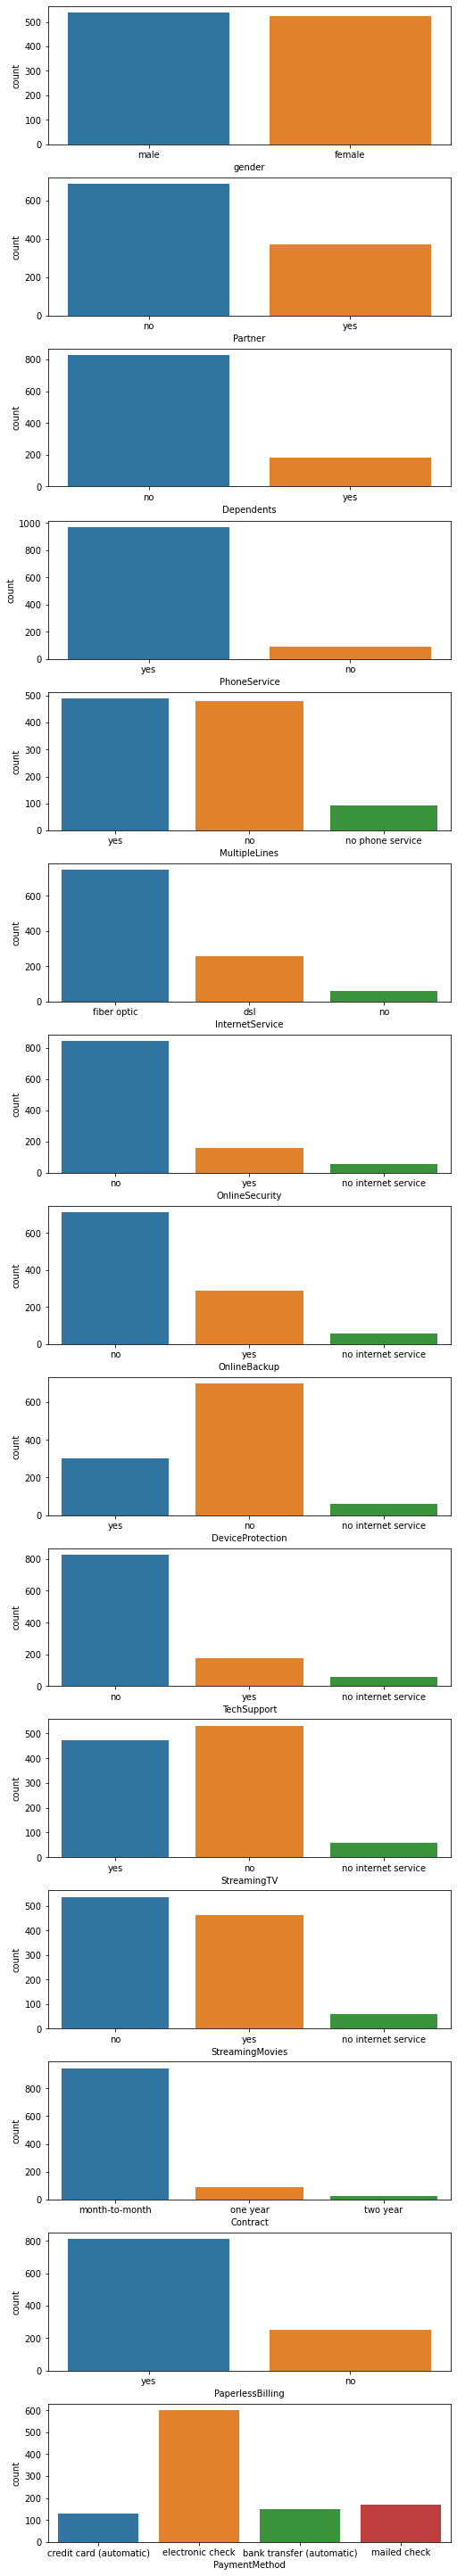

In [13]:
# Verificando a distribuição e características das variáveis categóricas em usuários que deixaram de utilizar a empresa

display(train.loc[df['Churn'] == 1].mode())

fig, ax = plt.subplots(len(colunas_categoricas), 1, layout='constrained', figsize=(7, 40))
num = 0

for feature in colunas_categoricas:
    sns.countplot(data=train.loc[train['Churn'] == 1], x=train.loc[train['Churn'] == 1][feature], ax=ax[num])
    num += 1

## Pré-processamento dos dados

In [14]:
# Verificando as colunas com missing data

train.isna().sum()

gender                0
SeniorCitizen         0
Partner               0
Dependents          146
tenure              321
PhoneService          0
MultipleLines         0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
Contract              0
PaperlessBilling      0
PaymentMethod        68
MonthlyCharges        0
TotalCharges          5
Churn                 0
dtype: int64

In [15]:
# Utilizando o método KNNImputer para preencher os valores numéricos ausentes no dataset de Treino.
impute_knn = KNNImputer(n_neighbors=3)
train[['tenure', 'TotalCharges']] = impute_knn.fit_transform(train[['tenure', 'TotalCharges']])

# Preenchendo os valores categóricos ausentes com a categoria 'missing no dataset de Treino'
impute_categorical = SimpleImputer(strategy='constant', fill_value='missing')
train[['Dependents', 'PaymentMethod']] = impute_categorical.fit_transform(train[['Dependents', 'PaymentMethod']])

In [16]:
# Criando listas com as variáveis categoricas nominais e ordinais.
ordinal_features = ['InternetService', 'Contract', 'PaymentMethod']
nominal_features = [feature for feature in colunas_categoricas if feature not in ordinal_features]

# Para as variáveis categóricas ordinais, foi definido o "rank" para cada valor/categoria.
InternetServiceRank = ['fiber optic', 'dsl', 'no']
ContractRank = ['two year', 'one year', 'month-to-month']
PaymentMethodRank = ['credit card (automatic)', 'bank transfer (automatic)', 'electronic check', 'mailed check', 'bank transfer (automatic)', 'missing']

# Aplicando o OrdinalEncoder nas variáveis ordinais.
oenc = OrdinalEncoder(categories=[InternetServiceRank, ContractRank, PaymentMethodRank])
train[ordinal_features] = oenc.fit_transform(train[ordinal_features])

# Apicando o OneHotEncoder nas variáveis nominais e separando o resultado em um dataframe.
ohe = OneHotEncoder(sparse=False, drop='first')
dados_ohe = pd.DataFrame(data=ohe.fit_transform(train[nominal_features]), columns=ohe.get_feature_names_out(), index=train[ordinal_features].index)

# unindo o dataframe criado ao dataframe de treino e excluindo as colunas que foram transformadas.
train = train.merge(dados_ohe, right_index=True, left_index=True).drop(nominal_features, axis=1)

In [17]:
# Realizando a normalização dos dados

scaler = MinMaxScaler()
train[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(train[['tenure', 'MonthlyCharges', 'TotalCharges']])

In [18]:
colunas_numericas

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']

In [19]:
val.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents          27
tenure              46
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        6
MonthlyCharges       0
TotalCharges         1
Churn                0
dtype: int64

### Validando o modelo

In [20]:
# Criando uma função para aplicar o pré processamento realizado no Treino
def aplicando_preproc(df):
    
    # Imputando missing Values
    df[['tenure', 'TotalCharges']] = impute_knn.transform(df[['tenure', 'TotalCharges']])
    df[['Dependents', 'PaymentMethod']] = impute_categorical.transform(df[['Dependents', 'PaymentMethod']])
    
    #Tratando os dados ordinais
    df[ordinal_features] = oenc.transform(df[ordinal_features])
    
    #Tratando os dados nominais
    dados_ohe = pd.DataFrame(data=ohe.transform(df[nominal_features]),
                                                 columns=ohe.get_feature_names_out(),
                                                 index=df[ordinal_features].index)
    df = df.merge(dados_ohe, right_index=True, left_index=True).drop(nominal_features, axis=1)
    
    #Normalizando os dados
    df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])
    
    return df

# Aplicando as transformações no dataset de validação
val = aplicando_preproc(val)

In [21]:
# Separando a variável target do dataframe

X_train = train.drop('Churn', axis=1)
y_train = train['Churn']

X_val = val.drop('Churn', axis=1)
y_val = val['Churn']

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((3943, 27), (3943,), (564, 27), (564,))

In [22]:
# Fazendo uma seleção de diversos modelos para verificar qual possui maior score em uma validação cruzada

classifiers = {
    'Regressão logística':LogisticRegression(max_iter = 1000),
    'DecisionTree':DecisionTreeClassifier(),
    'RandomForest':RandomForestClassifier(),
    'AdaBoost':AdaBoostClassifier(),
    'GradientBoost':GradientBoostingClassifier(),
    'XGBoost':XGBClassifier(random_state=42, objective='binary:logistic', eval_metric='error'),
    'KNN':KNeighborsClassifier(3),
    'Baggin':BaggingClassifier()
}

for key, value in classifiers.items():
    
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    
    model = value
    model.fit(X_train, y_train)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1')
    
    print(key)
    print(f'f1 score = {scores.mean():.3f}, std = {scores.std():.3f}')
    print('')

Regressão logística
f1 score = 0.601, std = 0.049

DecisionTree
f1 score = 0.521, std = 0.036

RandomForest
f1 score = 0.582, std = 0.049

AdaBoost
f1 score = 0.618, std = 0.045

GradientBoost
f1 score = 0.601, std = 0.044

XGBoost
f1 score = 0.569, std = 0.037

KNN
f1 score = 0.532, std = 0.032

Baggin
f1 score = 0.540, std = 0.038



In [23]:
# Como o modelo "AdaBoost" conseguiu o maior score, será validado seu desempenho na base de validação.

model = AdaBoostClassifier()
model.fit(X_train, y_train)

val['predict'] = model.predict(X_val)

val[['predict', 'Churn']]

,predict,Churn
2815,0,0
2273,0,0
2706,1,1
5208,0,0
2440,1,1
...,...,...
805,0,1
2486,1,0
2459,1,0
152,0,1


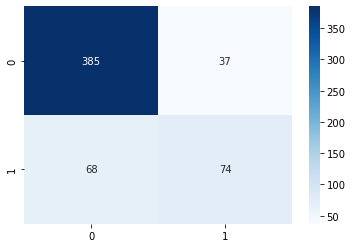

In [24]:
# Criando uma matriz de confusão para verificar onde o modelo está errando mais. Como a base é desbalanceada, há uma tendência
# de erro nos falsos positvos.

cm = confusion_matrix(val['Churn'], val['predict'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.show()

In [25]:
# Cálculo da acurácia balanceada.

balanced_accuracy_score(val['Churn'], val['predict'])

0.7167245177224484

In [26]:
# Cálculo do f1 score

f1_score(val['Churn'], val['predict'])

0.5849802371541502

### Feature Engineering

In [27]:
def feature_eng(df):
    
    # Criando uma variável para identificar quantos serviços o usuário adquiriu
    df['QtdServicos'] = df['MultipleLines_no phone service'] + df['MultipleLines_yes'] + df['OnlineSecurity_no internet service'] + df['OnlineSecurity_yes'] + df['OnlineBackup_no internet service'] + df['OnlineBackup_yes'] + df['DeviceProtection_no internet service'] + df['DeviceProtection_yes'] + df['TechSupport_no internet service'] + df['TechSupport_yes'] + df['StreamingTV_no internet service'] + df['StreamingTV_yes'] + df['StreamingMovies_no internet service'] + df['StreamingMovies_yes'] + df['PaperlessBilling_yes']
    
    # Tempo médio de permanencia (em anos)
    df['AvgTenure'] = df['tenure'] / 12
    
    # Valor médio mensal por serviço contratado pelo cliente
    df['avg_monthly_per_service'] = df['MonthlyCharges'] / df['QtdServicos']
    
    # Relação entre valor mensal cobrado e tempo de permanência do cliente na empresa
    df['monthly_charges_per_year'] = df['MonthlyCharges'] * 12 / df['tenure']
    
    # Relação entre valor total cobrado e número de serviços contratados pelo cliente
    df['total_charges_per_service'] = df['TotalCharges'] / df['QtdServicos']
    
    # Relação entre valor mensal cobrado e número de serviços contratados pelo cliente
    df['monthly_charges_per_service'] = df['MonthlyCharges'] / df['QtdServicos']
    
    df.replace([np.inf, -np.inf], 1e9, inplace=True)
    
    return df

In [28]:
X_train2 = feature_eng(X_train)
X_val2 = feature_eng(X_val)

In [29]:
X_train2.head()

,SeniorCitizen,tenure,InternetService,Contract,PaymentMethod,MonthlyCharges,TotalCharges,gender_male,Partner_yes,Dependents_no,Dependents_yes,PhoneService_yes,MultipleLines_no phone service,MultipleLines_yes,OnlineSecurity_no internet service,OnlineSecurity_yes,OnlineBackup_no internet service,OnlineBackup_yes,DeviceProtection_no internet service,DeviceProtection_yes,TechSupport_no internet service,TechSupport_yes,StreamingTV_no internet service,StreamingTV_yes,StreamingMovies_no internet service,StreamingMovies_yes,PaperlessBilling_yes,QtdServicos,AvgTenure,avg_monthly_per_service,monthly_charges_per_year,total_charges_per_service,monthly_charges_per_service
680,0,0.097222,0.0,2.0,0.0,0.707463,0.070742,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,0.008102,0.176866,87.321109,0.017685,0.176866
180,0,0.041667,2.0,2.0,3.0,0.015920,0.004431,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,6.0,0.003472,0.002653,4.585075,0.000739,0.002653
4181,0,0.861111,1.0,1.0,0.0,0.557711,0.539955,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,5.0,0.071759,0.111542,7.771979,0.107991,0.111542
1894,0,0.083333,2.0,2.0,3.0,0.019403,0.009180,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,7.0,0.006944,0.002772,2.794030,0.001311,0.002772
4013,0,0.722222,0.0,2.0,2.0,0.863682,0.646902,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,6.0,0.060185,0.143947,14.350402,0.107817,0.143947


In [30]:
model2 = AdaBoostClassifier()
model2.fit(X_train2, y_train)

val['predict_2'] = model2.predict(X_val2)

In [31]:
balanced_accuracy_score(val['Churn'], val['predict_2'])

0.7131032641345705

In [32]:
# Cálculo do f1.

f1_score(val['Churn'], val['predict_2'])

0.5757575757575757

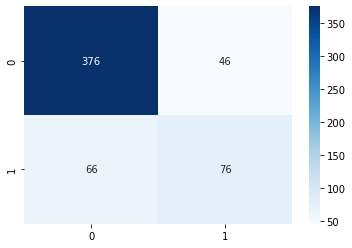

In [33]:
# Verificando a matriz de confusão

cm = confusion_matrix(val['Churn'], val['predict_2'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.show()

##### As modificações não garantiram melhores scores, sendo assim, o dataframe de test não será modificado

### Utilizando o modelo

In [34]:
# Aplicando as transformações do pré-processamento

test = aplicando_preproc(test)

X_test = test.drop('Churn', axis=1)
y_test = test['Churn']

X_test.shape, y_test.shape

((1127, 27), (1127,))

In [35]:
# Aplicando o modelo

test['predict'] = model.predict(X_test)

test[['predict', 'Churn']]

,predict,Churn
5594,1,0
3475,1,1
2548,0,0
2373,1,0
1033,0,0
...,...,...
334,0,0
1485,0,1
746,0,0
4702,0,0


In [36]:
# Cálculo da acurácia balanceada.

balanced_accuracy_score(test['Churn'], test['predict'])

0.7238516118448035

In [37]:
# Cálculo do f1.

f1_score(test['Churn'], test['predict'])

0.5945945945945946

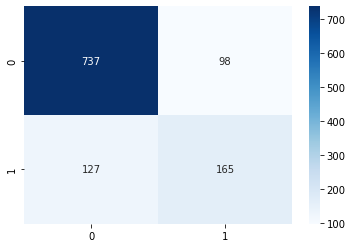

In [38]:
# Verificando a matriz de confusão

cm = confusion_matrix(test['Churn'], test['predict'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.show()